# Sensitivity Analysis
## Lukasz Zajac 

## 1. Proszę dokonać analizy czułości metodą Morrisa oraz Sobola.


### Model

In [28]:
def predator_prey_ode(t, y, params):
    """
    Defines the ODEs for the predator-prey system.

    Parameters:
    - t: Time
    - y: Current populations [population_A, population_B, population_C]
    - params: A dictionary containing all model parameters.

    Returns:
    - dydt: Derivatives [dA/dt, dB/dt, dC/dt]
    """
    A, B, C = y  # Unpack populations


    # Ensure populations are non-negative
    A = max(0, A)
    B = max(0, B)
    C = max(0, C)

    
    # Determine the most populated species and reduce its hunting efficiency
    most_populated = max(A, B, C)
    hunting_efficiency_factor = 1 - params['hunting_efficiency_reduction'] * (most_populated / (most_populated + 1))

    # Compute derivatives
    dA_dt = params['prey_growth_rate'] * A - hunting_efficiency_factor * params['predation_rate_A_by_B'] * A * B
    dB_dt = (
        -params['mortality_rate_B'] * B +
        hunting_efficiency_factor * params['reproduction_rate_B_from_A'] * A * B -
        hunting_efficiency_factor * params['predation_rate_B_by_C'] * B * C
    )
    dC_dt = (
        -params['mortality_rate_C'] * C +
        hunting_efficiency_factor * params['reproduction_rate_C_from_B'] * B * C -
        hunting_efficiency_factor * params['predation_rate_A_on_C'] * A * C
    )
    return [dA_dt, dB_dt, dC_dt]

### Params

In [2]:
# Define parameters with new hunting efficiency factor
parameters = {
    'prey_growth_rate': 0.02,                     # Growth rate of Species A (prey)
    'predation_rate_A_by_B': 0.005,               # Base predation rate of Species A by Species B
    'predation_rate_B_by_C': 0.002,               # Base predation rate of Species B by Species C
    'mortality_rate_B': 0.05,                     # Mortality rate of Species B
    'mortality_rate_C': 0.1,                     # Mortality rate of Species C
    'reproduction_rate_B_from_A': 0.01,           # Reproduction rate of Species B from consuming A
    'reproduction_rate_C_from_B': 0.01,           # Reproduction rate of Species C from consuming B
    'predation_rate_A_on_C': 0.001,               # Predation or harm rate of Species A on Species C
    'hunting_efficiency_reduction': 0.1,          # Reduction factor for most populated species' hunting efficiency
    'initial_population_A': 40,                   # Initial population of Species A (prey)
    'initial_population_B': 20,                   # Initial population of Species B (predator 1)
    'initial_population_C': 5,                   # Initial population of Species C (predator 2)
    'start_time': 0,                              # Start time for simulation
    'end_time': 1000                               # End time for simulation
}

### Plotting

In [3]:
import matplotlib.pyplot as plt

def plot_results(t, pop_A, pop_B, pop_C):
    """
    Plots the results of a predator-prey simulation.

    Parameters:
    - t: Array of time points
    - pop_A, pop_B, pop_C: Population dynamics for Species A, B, and C
    """
    plt.figure(figsize=(12, 7))
    plt.plot(t, pop_A, label='Species A (Prey)', color='green')
    plt.plot(t, pop_B, label='Species B (Predator 1)', color='blue')
    plt.plot(t, pop_C, label='Species C (Predator 2)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Predator-Prey Dynamics with Hunting Efficiency Reduction')
    plt.legend()
    plt.grid()
    plt.show()

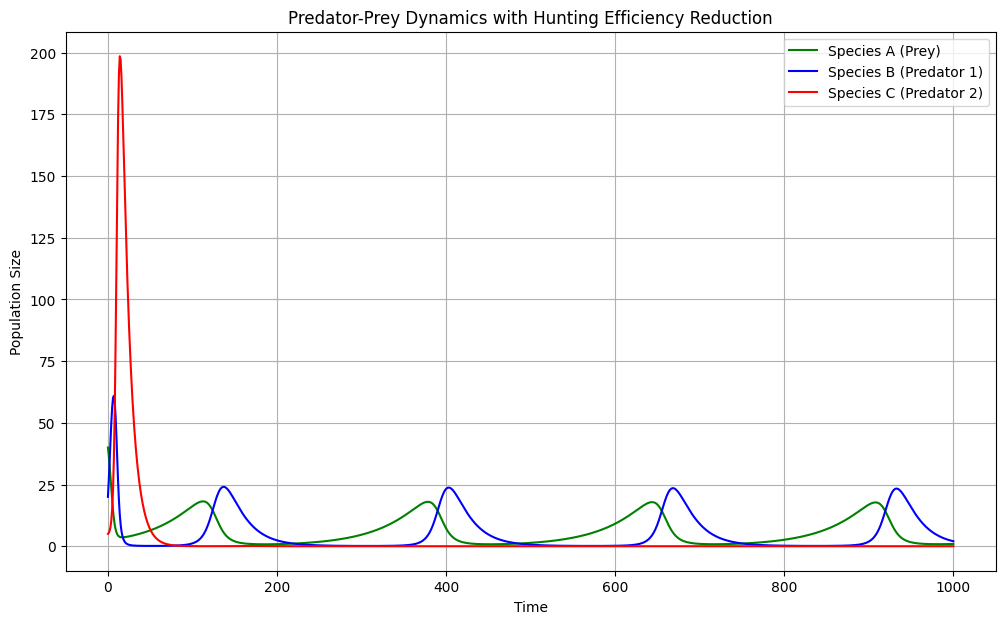

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e+00 ...  9.990e+02  1.000e+03]
        y: [[ 4.000e+01  3.673e+01 ...  9.137e-01  9.233e-01]
            [ 2.000e+01  2.668e+01 ...  2.097e+00  2.012e+00]
            [ 5.000e+00  5.397e+00 ...  2.201e-18  2.029e-18]]
      sol: None
 t_events: None
 y_events: None
     nfev: 525
     njev: 0
      nlu: 0

In [24]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.integrate import solve_ivp
import numpy as np


def evaluate_model_and_plot( 
    model, 
    params,
    y_0,
    plot=False
    ):
    solution = solve_ivp(
        fun=lambda t, y: model(t, y, params),
        t_span=[params['start_time'], params['end_time']],
        y0=y_0,
        t_eval=np.linspace(params['start_time'], params['end_time'], params['end_time'] - params['start_time']),
        method="LSODA"
    )
    if plot:
        plot_results(solution.t, solution.y[0], solution.y[1], solution.y[2])
    return solution

evaluate_model_and_plot(
    predator_prey_ode, 
    parameters, 
    [   
     parameters['initial_population_A'], 
     parameters['initial_population_B'], 
     parameters['initial_population_C']
    ],
    True)

### Morris Method

#### problem

In [6]:
problem = {
    "num_vars": 12,
    "names": 
        [
         "prey_growth_rate",
         "predation_rate_A_by_B", 
         "predation_rate_B_by_C", 
         "mortality_rate_B", 
         "mortality_rate_C", 
         "reproduction_rate_B_from_A", 
         "reproduction_rate_C_from_B", 
         "predation_rate_A_on_C", 
         "hunting_efficiency_reduction", 
         "initial_population_A", 
         "initial_population_B",
         "initial_population_C"
        ],
    "bounds": 
        [
            [0.01, 0.1], # growth rate of species A
            [0.001, 0.01], # predation rate of species A by species B
            [0.001, 0.01], # predation rate of species A by species B
            [0.01, 0.1], # mortality rate of species B
            [0.01, 0.1], # mortality rate of species B
            [0.001, 0.01], # reproduction rate of species B from species A
            [0.001, 0.01], # reproduction rate of species C from species B
            [0.001, 0.01], # predation rate of species A on species C
            [0.01, 0.1], # reduction factor for hunting efficiency
            [10, 100],# initial population of species A
            [10, 100], # initial population of species B
            [10, 100] # initial population of species C
        ]
    }

#### sampling


In [34]:
#morris method
from SALib.analyze import morris
from SALib.sample.morris import sample
from scipy.integrate import solve_ivp
import numpy as np

# sample the parameter space
param_values = sample(problem, 500, num_levels=4)
print(param_values.shape)

(6500, 12)


#### evaluate on sampled params

In [35]:
import tqdm

evaluated =[]

for row in tqdm.tqdm(param_values):
    params_w_names = dict(zip(problem['names'], row))
    params_w_names["start_time"] = 0
    params_w_names["end_time"] = 600
    solution = evaluate_model_and_plot(
        predator_prey_ode, 
        params_w_names, 
        [   
         np.float64(params_w_names['initial_population_A']), 
         np.float64(params_w_names['initial_population_B']), 
         np.float64(params_w_names['initial_population_C'])
        ],
        False)
    evaluated.append(solution.y)
    
evaluated = np.array(evaluated, dtype=np.float64)
print(evaluated.shape)

100%|██████████| 6500/6500 [01:18<00:00, 83.00it/s] 


(6500, 3, 600)


#### morris requires one value from each timespan. Ill use for that average


In [36]:
evaluated_summarized = evaluated.mean(axis=2)
evaluated_summarized.shape

(6500, 3)

#### analyze

In [39]:
Si_list = []

species_names = ["Species A", "Species B", "Species C"]
for idx, species_name in enumerate(species_names):
    # Select the summarized output for this species
    output_i = evaluated_summarized[:, idx]
    # Perform Morris analysis
    Si = morris.analyze(
        problem=problem,
        X=param_values,
        Y=output_i, 
        print_to_console=False,
        num_levels=4
    )
    Si_list.append((species_name, Si))
    
    


Species A: (6500,)
Species B: (6500,)
Species C: (6500,)
Species A
{'names': array(['prey_growth_rate', 'predation_rate_A_by_B',
       'predation_rate_B_by_C', 'mortality_rate_B', 'mortality_rate_C',
       'reproduction_rate_B_from_A', 'reproduction_rate_C_from_B',
       'predation_rate_A_on_C', 'hunting_efficiency_reduction',
       'initial_population_A', 'initial_population_B',
       'initial_population_C'], dtype='<U28'), 'mu': masked_array(data=[9.72429495599319e+21, -4.241197465362613e+22,
                   1.3627033748528562e+20, -4.3583623484142387e+21,
                   -1.4591797470045317e+22, -4.716854746352281e+21,
                   1.7066553814877068e+22, -2.9061441054866124e+22,
                   4.904142886080726e+21, -2.6530991322005405e+22,
                   -1.880530821442924e+22, -3.948758414339443e+20],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20), 'mu_sta

#### plotting

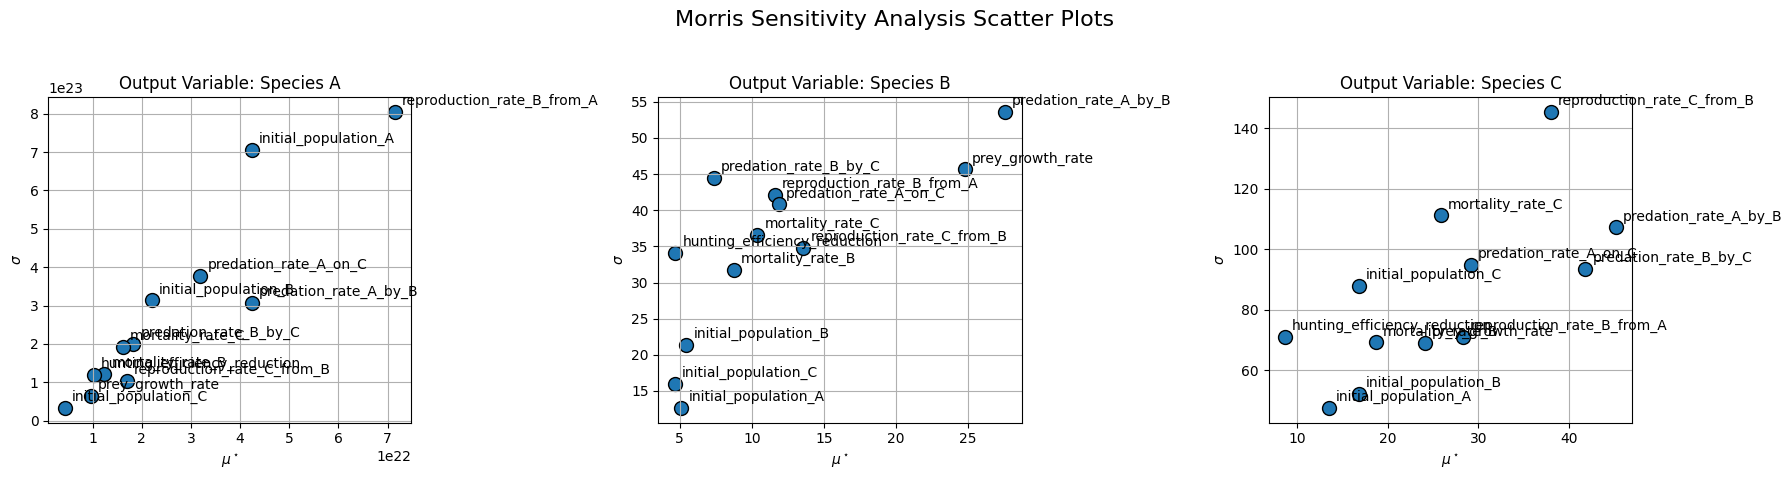

In [50]:
cols = 3
rows = int(np.ceil(len(Si_list) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
fig.suptitle(r"Morris Sensitivity Analysis Scatter Plots", fontsize=16)

for i, (var_name, Si) in enumerate(Si_list):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    mu_star = Si["mu_star"]
    sigma = Si["sigma"]
    param_names = problem["names"]

    ax.scatter(mu_star, sigma, s=100, edgecolors="k")
    for j, txt in enumerate(param_names):
        ax.annotate(
            txt, (mu_star[j], sigma[j]), textcoords="offset points", xytext=(5, 5)
        )

    ax.set_xlabel(r"$\mu^\star$")
    ax.set_ylabel(r"$\sigma$")
    ax.set_title(f"Output Variable: {var_name}")
    ax.grid(True)

total_plots = rows * cols
if total_plots > len(Si_list):
    for i in range(len(Si_list), total_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Sobol method

#### sample

In [51]:
from SALib.sample import sobol

param_values = sobol.sample(problem, N=512)

#### evaluate on sampled params

In [52]:
import tqdm

evaluated =[]

for row in tqdm.tqdm(param_values):
    params_w_names = dict(zip(problem['names'], row))
    params_w_names["start_time"] = 0
    params_w_names["end_time"] = 600
    solution = evaluate_model_and_plot(
        predator_prey_ode, 
        params_w_names, 
        [   
         params_w_names['initial_population_A'], 
         params_w_names['initial_population_B'], 
         params_w_names['initial_population_C']
        ],
        False)
    evaluated.append(solution.y)
    
evaluated = np.array(evaluated)
print(evaluated.shape)

100%|██████████| 13312/13312 [02:32<00:00, 87.29it/s] 

(13312, 3, 600)


#### analyze

In [55]:
from SALib.analyze import sobol
Si_list = []

species_names = ["Species A", "Species B", "Species C"]
for idx, species_name in enumerate(species_names):
    # Select the summarized output for this species
    output_i = evaluated_summarized[:, idx]
    # Perform Morris analysis
    Si = sobol.analyze(
        problem=problem,
        Y=output_i, 
        print_to_console=False,
    )
    Si_list.append((species_name, Si))
    


e:\Users\qesterius\Documents\Studia\ComplexSystems\.venv\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


#### plotting

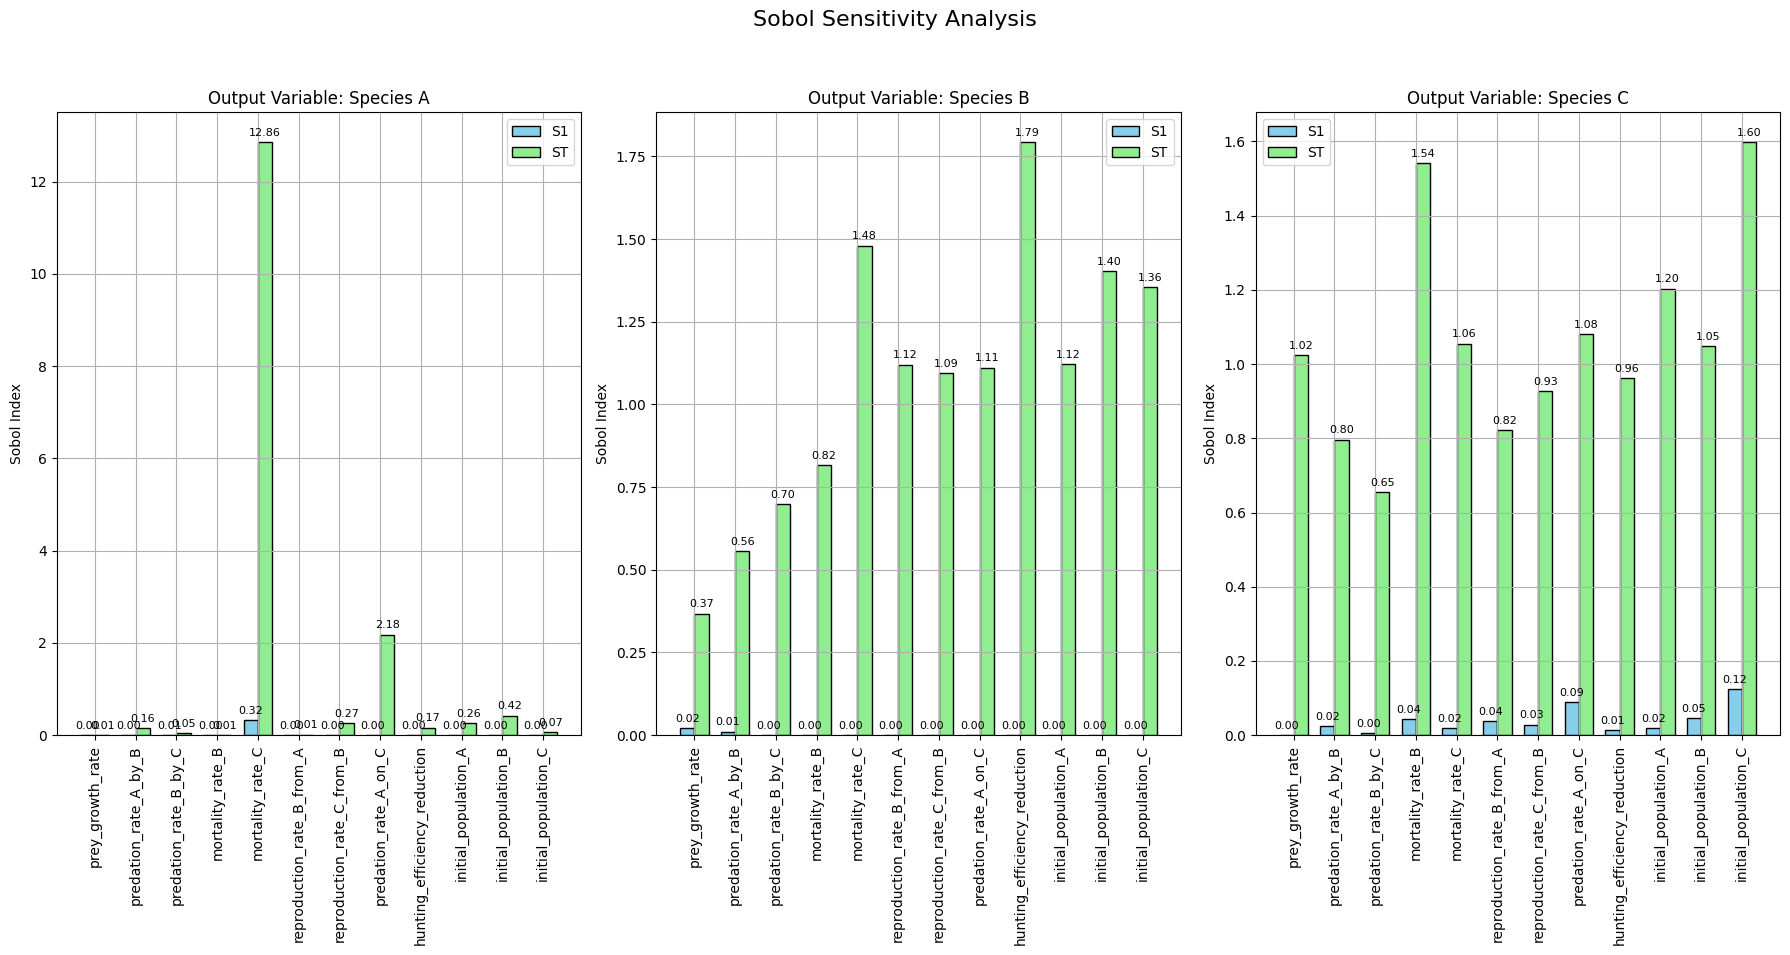

In [57]:
#plot sobol results
import matplotlib.pyplot as plt
import numpy as np

cols = 3
rows = int(np.ceil(len(Si_list) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 10))
fig.suptitle("Sobol Sensitivity Analysis", fontsize=16)

for i, (var_name, Si) in enumerate(Si_list):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    indices = Si["S1"]
    indices_conf = Si["S1_conf"]
    total_indices = Si["ST"]
    total_conf = Si["ST_conf"]
    param_names = problem["names"]

    indices = np.where(indices >= 0, indices, 0)
    total_indices = np.where(total_indices >= 0, total_indices, 0)

    ind = np.arange(len(param_names))
    width = 0.35

    bars1 = ax.bar(
        ind,
        indices,
        width,
        label="S1",
        color="skyblue",
        edgecolor="k",
        capsize=5,
    )

    bars2 = ax.bar(
        ind + width,
        total_indices,
        width,
        label="ST",
        color="lightgreen",
        edgecolor="k",
        capsize=5,
    )

    def add_labels(bars, values):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.annotate(
                f"{value:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    add_labels(bars1, indices)
    add_labels(bars2, total_indices)

    ax.set_ylabel("Sobol Index")
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(param_names, rotation=90)
    ax.set_title(f"Output Variable: {var_name}")
    ax.legend()
    ax.grid(True)

total_plots = rows * cols
if total_plots > len(Si_list):
    for i in range(len(Si_list), total_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 


## 2. Porównać otrzymane wyniki dt parametrów modelu oraz wartości początkowych, Morrisa, S1, ST. 
Skomentować otrzymane wyniki.




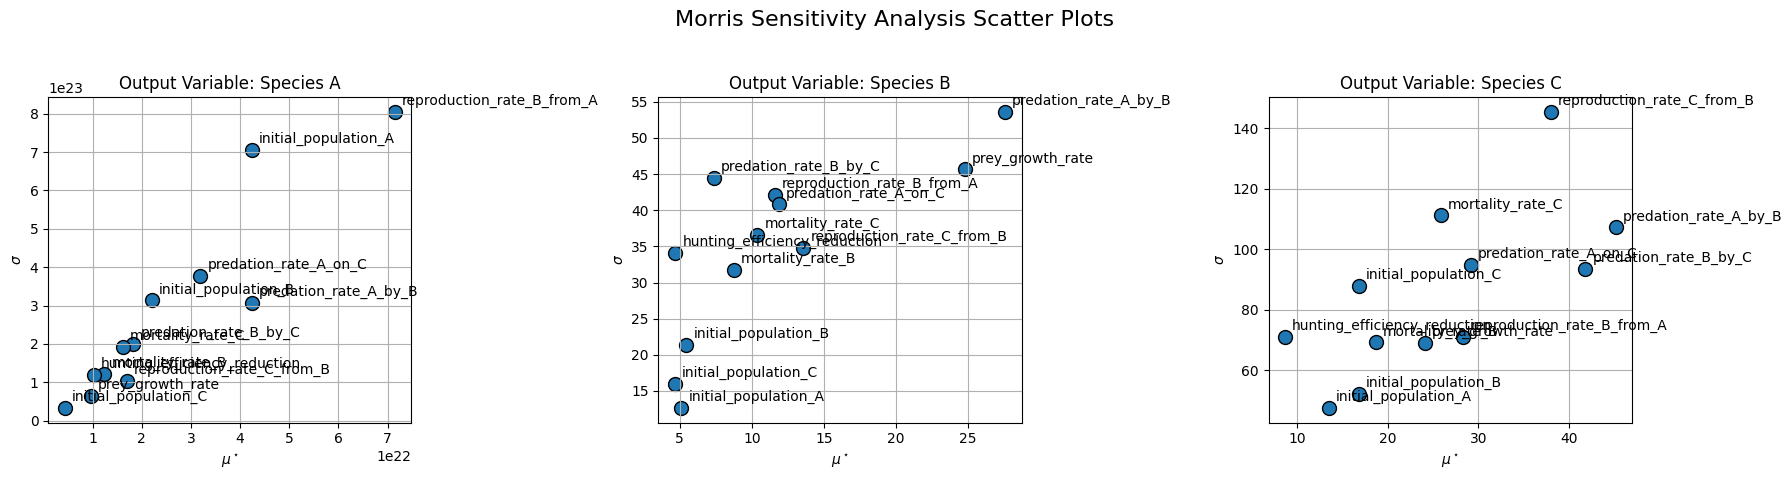

A:

    MOST SENSITIVE:
        Morris:
            reproduction_rate_B_from_A
            predation_rate_A_by_B
            initial_population_A
            predation_rate_A_on_C
        SOBOL:
            mortality_rate_C
            predation_rate_A_on_C

    LEAST SENSITIVE:
        Morris:
            initial_population_C
            prey_growth_rate
        Sobol
            prey_growth_rate
            mortality_rate_B

B:  

    MOST SENSITIVE:
        
        Morris:
            "predation_rate_A_by_B"
            "prey_growth_rate"  # initial pop B is not that important

        Sobol:
            "hunting_efficiency_reduction"
            mortality_rate_C
            "initial_population_B",
            "initial_population_C"

    LEAST SENSITIVE:
        Morris:
            "initial_population_C"
            "hunting_efficiency_reduction"
            "initial_population_A", 
        SOBOL:
            prey_growth_rate
            predation_rate_A_by_B

I wont write same for C ...


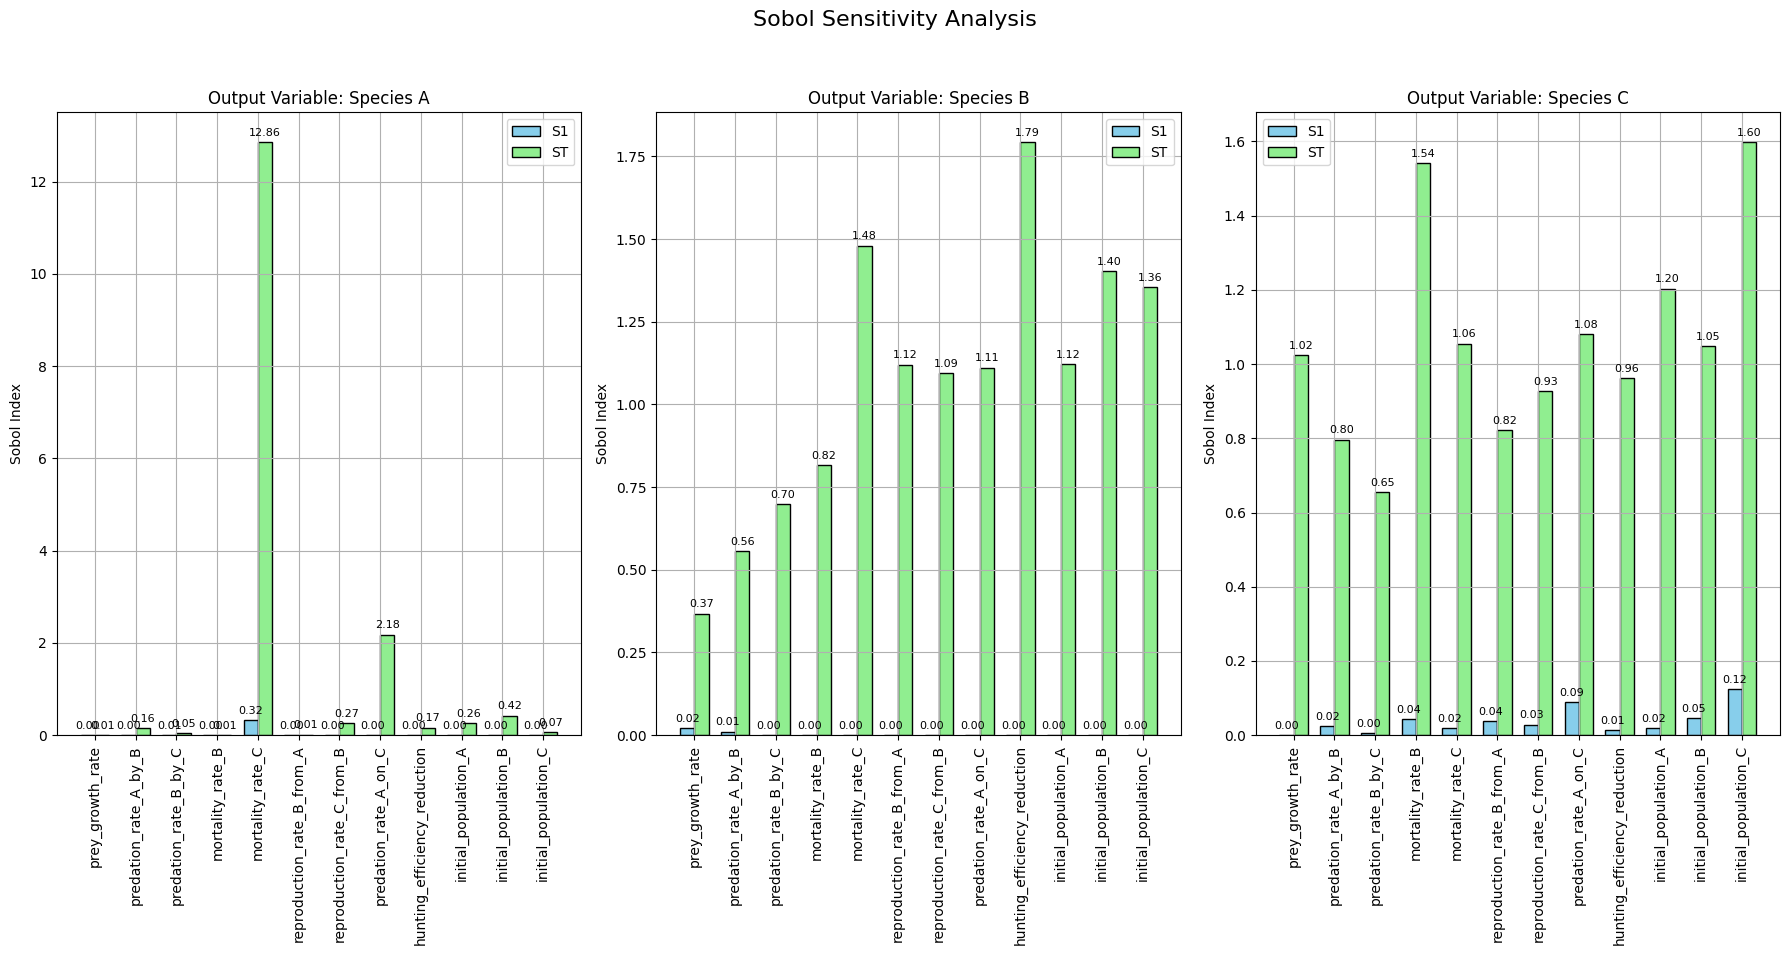

## 3. Parametry najmniej czułe ustawić na stałe wartości trochę inne niż w modelu bazowym.
Porównać wyniki z modelem bazowym (zdefiniować taki model) dla różnej wartości parametrów o najwyższej czułości.
Czy rzeczywiście tak od siebie odbiegają wyniki dla modelu base i tym ze zmienionymi parametrami o najaniższej czułości.
Zebrać wnioski z wykonanych eksperymentów.
Jak analiza czułości może być używana do interpretacji wyników symulacji.

sprawdze na zmiennej A

In [70]:
results = {}

results["base_model"] = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters, 
    [   
     parameters['initial_population_A'], 
     parameters['initial_population_B'], 
     parameters['initial_population_C']
    ],
    False).y[0]


In [71]:
parameters_low_impact = parameters.copy()
parameters_low_impact["initial_population_C"] = parameters["initial_population_C"] * 1.2
parameters_low_impact["prey_growth_rate"] = parameters["prey_growth_rate"] * 1.2
parameters_low_impact["mortality_rate_B"] = parameters["mortality_rate_B"] * 1.2

print("Low impact model")
results["low_impact"] = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters_low_impact, 
    [   
     parameters_low_impact['initial_population_A'], 
     parameters_low_impact['initial_population_B'], 
     parameters_low_impact['initial_population_C']
    ],
    False).y[0]


Low impact model


In [72]:

parameters_high_impact = parameters.copy()
parameters_high_impact["reproduction_rate_B_from_A"] = parameters["reproduction_rate_B_from_A"] * 1.2
results["high_impact_1"] = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters_high_impact, 
    [   
     parameters_high_impact['initial_population_A'], 
     parameters_high_impact['initial_population_B'], 
     parameters_high_impact['initial_population_C']
    ],
    False).y[0]


In [73]:
parameters_high_impact["predation_rate_A_on_C"] = parameters["predation_rate_A_on_C"] * 1.2
print("High impact model 2 params")
results["high_impact_2"] = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters_high_impact, 
    [   
     parameters_high_impact['initial_population_A'], 
     parameters_high_impact['initial_population_B'], 
     parameters_high_impact['initial_population_C']
    ],
    False).y[0]


High impact model 2 params


In [74]:
parameters_high_impact["predation_rate_A_by_B"] = parameters["predation_rate_A_by_B"] * 1.2
print("High impact model 3 params")
results["high_impact_3"] = evaluate_model_and_plot(
    predator_prey_ode, 
    parameters_high_impact, 
    [   
     parameters_high_impact['initial_population_A'], 
     parameters_high_impact['initial_population_B'], 
     parameters_high_impact['initial_population_C']
    ],
    False).y[0]

High impact model 3 params


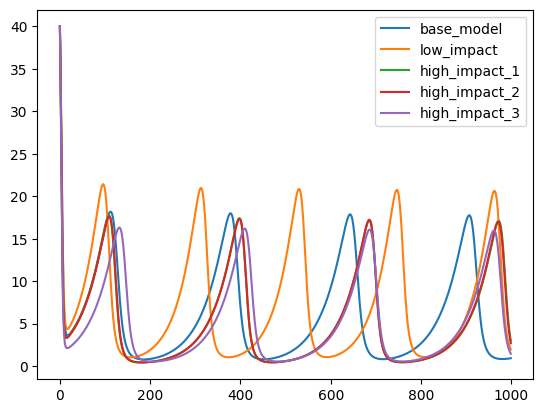

In [75]:
for key in results:
    plt.plot(results[key], label=key)
plt.legend()

Whats sensitive for A by Morris is unsensitive by Sobel and the other way around. These methods didnt work that well here. One of problems I see is that Morris takes some aggregated value from timeseries and I took average. Its okay, but if series goes uncontrollably average does not know about it. Sobol on the other hand does not take all information into analysis (parameter values). Its unclear if parameter impact is relative to its absolute value or not?